In [3]:
!nvidia-smi


Thu Nov  7 13:26:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Install PyTorch with CUDA 12.x support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [21]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU name: Tesla T4


In [1]:
!pip uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip install torch torchaudio torchvision torchtext torchdata

Found existing installation: torch 2.5.0+cu121
Uninstalling torch-2.5.0+cu121:
  Successfully uninstalled torch-2.5.0+cu121
Found existing installation: torchaudio 2.5.0+cu121
Uninstalling torchaudio-2.5.0+cu121:
  Successfully uninstalled torchaudio-2.5.0+cu121
Found existing installation: torchvision 0.20.0+cu121
Uninstalling torchvision-0.20.0+cu121:
  Successfully uninstalled torchvision-0.20.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [25]:
import tempfile
from pathlib import Path
from urllib.request import urlretrieve


video_path = "/content/drive/MyDrive/RAFT/TEST3.mp4"

In [7]:
!pip install PyAV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 63.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


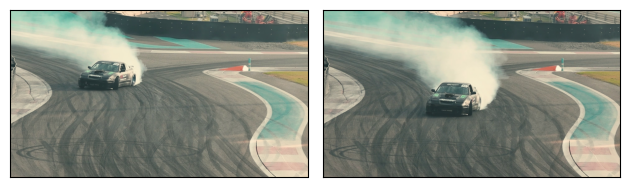

In [26]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path), output_format="TCHW")

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

In [27]:
from torchvision.models.optical_flow import Raft_Large_Weights
import torchvision.transforms as T

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch


In [28]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

# list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
# print(f"type = {type(list_of_flows)}")
# print(f"length = {len(list_of_flows)} = number of iterations of the model")

In [9]:
# predicted_flows = list_of_flows[-1]
# print(f"dtype = {predicted_flows.dtype}")
# print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
# print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -12.59498405456543, max = 31.895030975341797


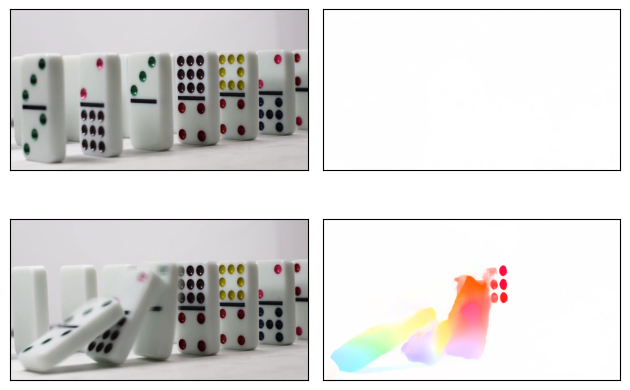

In [10]:
# from torchvision.utils import flow_to_image

# flow_imgs = flow_to_image(predicted_flows)

# # The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
# img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

# grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
# plot(grid)

In [29]:
from torchvision.io import write_jpeg
from torchvision.utils import flow_to_image
import os

output_folder = "/content/drive/MyDrive/output_flow2/"
os.makedirs(output_folder, exist_ok=True)  # Create output directory if it doesn't exist
for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1 = preprocess(img1[None]).to(device)
    img2= preprocess(img2[None]).to(device)

    list_of_flows = model(img1, img2)
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")
    del img1, img2, list_of_flows, predicted_flow
    torch.cuda.empty_cache()

In [30]:
import cv2
import os

# Specify the output video path
video_output_path = "/content/drive/MyDrive/output_flow2/output_video0.avi"

# Get a list of the saved flow images
flow_images = [f for f in os.listdir(output_folder) if f.endswith('.jpg')]
flow_images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
print(flow_images)
# Read the first image to get its dimensions
first_frame = cv2.imread(os.path.join(output_folder, flow_images[0]))
height, width, _ = first_frame.shape

# Define the video codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MP4V' or 'MJPG'
video_writer = cv2.VideoWriter(video_output_path, fourcc, 20, (width, height))  # 20 fps, adjust as needed

# Add images to the video
for image_name in flow_images:
    img_path = os.path.join(output_folder, image_name)
    frame = cv2.imread(img_path)
    video_writer.write(frame)

# Release the video writer
video_writer.release()

print(f"Video saved to {video_output_path}")


['predicted_flow_0.jpg', 'predicted_flow_1.jpg', 'predicted_flow_2.jpg', 'predicted_flow_3.jpg', 'predicted_flow_4.jpg', 'predicted_flow_5.jpg', 'predicted_flow_6.jpg', 'predicted_flow_7.jpg', 'predicted_flow_8.jpg', 'predicted_flow_9.jpg', 'predicted_flow_10.jpg', 'predicted_flow_11.jpg', 'predicted_flow_12.jpg', 'predicted_flow_13.jpg', 'predicted_flow_14.jpg', 'predicted_flow_15.jpg', 'predicted_flow_16.jpg', 'predicted_flow_17.jpg', 'predicted_flow_18.jpg', 'predicted_flow_19.jpg', 'predicted_flow_20.jpg', 'predicted_flow_21.jpg', 'predicted_flow_22.jpg', 'predicted_flow_23.jpg', 'predicted_flow_24.jpg', 'predicted_flow_25.jpg', 'predicted_flow_26.jpg', 'predicted_flow_27.jpg', 'predicted_flow_28.jpg', 'predicted_flow_29.jpg', 'predicted_flow_30.jpg', 'predicted_flow_31.jpg', 'predicted_flow_32.jpg', 'predicted_flow_33.jpg', 'predicted_flow_34.jpg', 'predicted_flow_35.jpg', 'predicted_flow_36.jpg', 'predicted_flow_37.jpg', 'predicted_flow_38.jpg', 'predicted_flow_39.jpg', 'predicte